**LOAD DEPENDENCIES**

In [ ]:
#import the neccessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
import tensorflow_io as tfio
from sklearn.preprocessing import LabelEncoder
import glob
import pickle

**PREPROCESSING OF AUDIO FILES**

In [ ]:
# Directory containing the audio files
folder_path = '/content/drive/MyDrive/arc/cats_dogs'

# Search for WAV files in the folder
wav_files = glob.glob(os.path.join(folder_path, '*.wav'))

# Create a DataFrame to store filename and category
data = []

# Iterate through each WAV file
for file_path in wav_files:
    # Extract filename and category from the file path
    filename = os.path.basename(file_path)
    category = filename.split('_')[0]  # Get the category from the filename

    # Append filename and category to the data list
    data.append([filename, category])

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Filename', 'Class'])





In [ ]:
df.to_csv('/content/drive/MyDrive/arc/cat_dog.csv', index=False)

In [ ]:
df.head()

,Filename,Class
0,cat_10.wav,cat
1,cat_1.wav,cat
2,cat_106.wav,cat
3,cat_107.wav,cat
4,cat_105.wav,cat


**CREATE DATA LOADING FUNCTION**

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

PLOT THE WAVE FILES

In [ ]:

wav1=load_wav_16k_mono('/content/drive/MyDrive/arc/cats_dogs/cat_1.wav')
wav2=load_wav_16k_mono('/content/drive/MyDrive/arc/cats_dogs/dog_barking_1.wav')

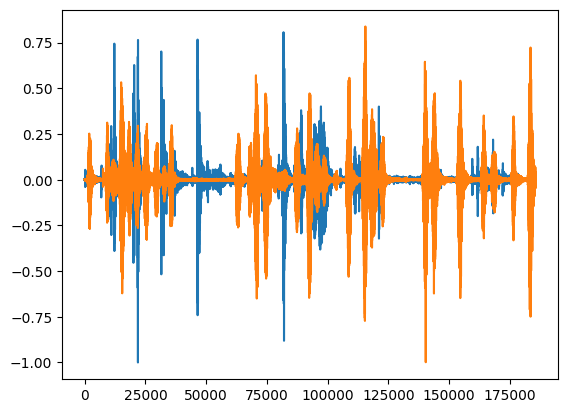

In [ ]:
plt.plot(wav1)
plt.plot(wav2)
plt.show()

In [ ]:
#path for the folder containing the wav files
audio_dataset_path='/content/drive/MyDrive/arc/cats_dogs'

In [ ]:
# Function to process a single row of the DataFrame and to give samples data of each audio  files with label
lengths=[]
for index, row in df.iterrows():
          file_name = row['Filename']
          label = row['Class']
          file_path =os.path.join(os.path.abspath(audio_dataset_path),str(file_name))
          length=len(load_wav_16k_mono(file_path))
          lengths.append((length,label))

In [ ]:
lengths

[(150208, 'cat'),
 (179200, 'cat'),
 (192000, 'cat'),
 (192000, 'cat'),
 (190400, 'cat'),
 (192000, 'cat'),
 (20696, 'cat'),
 (182400, 'cat'),
 (184000, 'cat'),
 (132291, 'cat'),
 (20352, 'cat'),
 (190400, 'cat'),
 (233408, 'cat'),
 (30583, 'cat'),
 (93696, 'cat'),
 (79296, 'cat'),
 (287616, 'cat'),
 (192000, 'cat'),
 (179200, 'cat'),
 (127315, 'cat'),
 (66432, 'cat'),
 (17280, 'cat'),
 (32192, 'cat'),
 (134400, 'cat'),
 (85888, 'cat'),
 (100992, 'cat'),
 (69056, 'cat'),
 (177600, 'cat'),
 (22152, 'cat'),
 (25344, 'cat'),
 (19968, 'cat'),
 (243072, 'cat'),
 (89098, 'cat'),
 (192000, 'cat'),
 (176000, 'cat'),
 (168000, 'cat'),
 (20063, 'cat'),
 (182400, 'cat'),
 (161792, 'cat'),
 (15067, 'cat'),
 (15067, 'cat'),
 (94342, 'cat'),
 (185992, 'cat'),
 (79942, 'cat'),
 (19227, 'cat'),
 (63296, 'cat'),
 (15067, 'cat'),
 (16614, 'cat'),
 (19867, 'cat'),
 (192000, 'cat'),
 (192000, 'cat'),
 (192000, 'cat'),
 (33728, 'cat'),
 (62592, 'cat'),
 (47168, 'cat'),
 (67200, 'cat'),
 (188800, 'cat'),
 (

In [ ]:
# Create a defaultdict to store the values for each class
class_values = defaultdict(list)

# Iterate over the list of tuples and store the values for each class
for value, label in lengths:
    class_values[label].append(value)

# Calculate the total, mean, min, and max samples for each class
class_stats = {}
for label, values in class_values.items():
    class_stats[label] = {
        'total': sum(values),
        'mean': sum(values) / len(values),
        'min': min(values),
        'max': max(values)
    }
class_stats


{'cat': {'total': 21182367,
  'mean': 129160.7743902439,
  'min': 14773,
  'max': 287616},
 'dog': {'total': 9575013,
  'mean': 84734.62831858407,
  'min': 16251,
  'max': 275203}}

**CREATE PREPROCESSING FUNCTION**

In [ ]:
def preprocess(file_path):
    # Load the WAV file and convert it to a tensor
    wav = load_wav_16k_mono(file_path)
    # Trim the audio to 25000 samples
    wav = wav[:25000]
    # Add zero padding to make the length 25000
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    # Compute the Short-Time Fourier Transform (STFT) of the audio
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # Compute the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)
    # Add a channel dimension to the spectrogram
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

PLOT THE SPECTROGRAM FOR THE WAV FILES

In [ ]:
cat_spectr=preprocess('/content/drive/MyDrive/arc/cats_dogs/cat_1.wav')
dog_spectr=preprocess('/content/drive/MyDrive/arc/cats_dogs/dog_barking_1.wav')


In [ ]:
cat_spectr,dog_spectr

(<tf.Tensor: shape=(772, 257, 1), dtype=float32, numpy=
 array([[[1.21135235e-01],
         [6.41008988e-02],
         [5.06470725e-02],
         ...,
         [2.77117564e-04],
         [1.87724974e-04],
         [7.62380660e-05]],
 
        [[1.52830243e-01],
         [1.20219775e-01],
         [1.07957721e-01],
         ...,
         [3.14820354e-04],
         [1.27740961e-04],
         [7.60704279e-06]],
 
        [[1.73161954e-01],
         [1.71579212e-01],
         [1.75858498e-01],
         ...,
         [4.41751326e-04],
         [1.61114338e-04],
         [1.07474625e-04]],
 
        ...,
 
        [[3.30835402e-01],
         [3.25157613e-01],
         [2.22464383e-01],
         ...,
         [2.85739137e-04],
         [1.82398420e-04],
         [2.19941139e-05]],
 
        [[1.26742065e-01],
         [3.11023653e-01],
         [4.17927027e-01],
         ...,
         [2.38632303e-04],
         [1.96863140e-04],
         [1.01484358e-04]],
 
        [[1.34906575e-01],
       

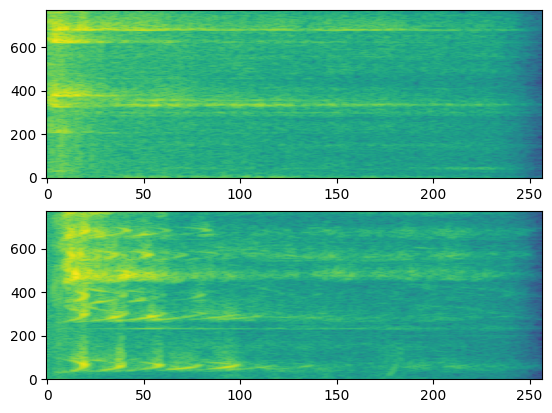

In [ ]:

fig, ax = plt.subplots(2)
# Accessing each axes object to plot the data
ax[0].imshow(tf.math.log(cat_spectr).numpy(), aspect='auto', origin='lower')
ax[1].imshow(tf.math.log(dog_spectr).numpy(), aspect='auto', origin='lower')


**CREATE  FUNCTION FOR PREPROCESSING WAV USING DATAFRAME**

In [ ]:
# Function to process a single row of the DataFrame
def process_row(row):
    file_name = row['Filename']
    label = row['Class']
    file_path =os.path.join(os.path.abspath(audio_dataset_path),str(file_name))
    spectrogram =preprocess(file_path)
    return spectrogram, label


**CREATE TRAIN AND TEST DATASET**

In [ ]:
# Apply the processing function to each row of the DataFrame
spectrogram_list, label_list = zip(*df.apply(process_row, axis=1))

In [ ]:
# Convert to numpy arrays
spectrogram_array = np.stack(spectrogram_list)
label_array = np.array(label_list)

In [ ]:
label_array

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat',

In [ ]:
#do label encoding for the target
label_encoder = LabelEncoder()
label_array = label_encoder.fit_transform(label_array)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectrogram_array, label_array, test_size=0.2, random_state=42,stratify=label_array)

**BUILD A DEEP LEARNING MODEL**

In [ ]:
# Define and compile CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input([772, 257, 1]),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming 2 classes
])






In [ ]:
#compile the model
model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

**TRAIN THE DEEP LEARNING MODEL**

In [ ]:
# Train the model
hist=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
6/6 [==============================] - 85s 14s/step - loss: 6.3581 - accuracy: 0.8580 - val_loss: 86.5480 - val_accuracy: 0.8000
Epoch 2/10
6/6 [==============================] - 82s 14s/step - loss: 2.9453 - accuracy: 0.9489 - val_loss: 58.4314 - val_accuracy: 0.8000
Epoch 3/10
6/6 [==============================] - 81s 14s/step - loss: 1.1447 - accuracy: 0.9602 - val_loss: 37.3528 - val_accuracy: 0.8444
Epoch 4/10
6/6 [==============================] - 97s 17s/step - loss: 0.5709 - accuracy: 0.9659 - val_loss: 28.6600 - val_accuracy: 0.8444
Epoch 5/10
6/6 [==============================] - 81s 14s/step - loss: 0.0940 - accuracy: 0.9886 - val_loss: 25.5487 - val_accuracy: 0.8444
Epoch 6/10
6/6 [==============================] - 82s 13s/step - loss: 0.0545 - accuracy: 0.9943 - val_loss: 22.0326 - val_accuracy: 0.8444
Epoch 7/10
6/6 [==============================] - 82s 14s/step - loss: 0.0447 - accuracy: 0.9830 - val_loss: 22.6421 - val_accuracy: 0.8444
Epoch 8/10
6/6 [====

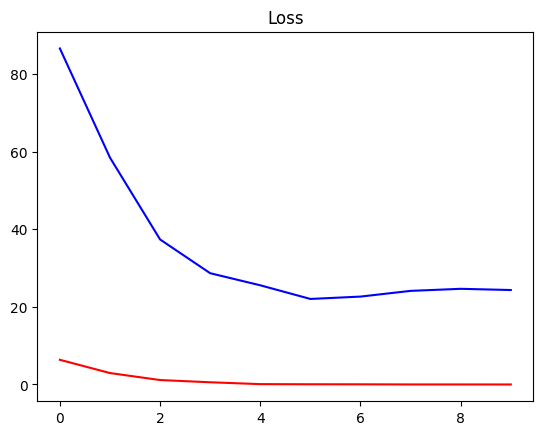

In [ ]:
#Plot the loss
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

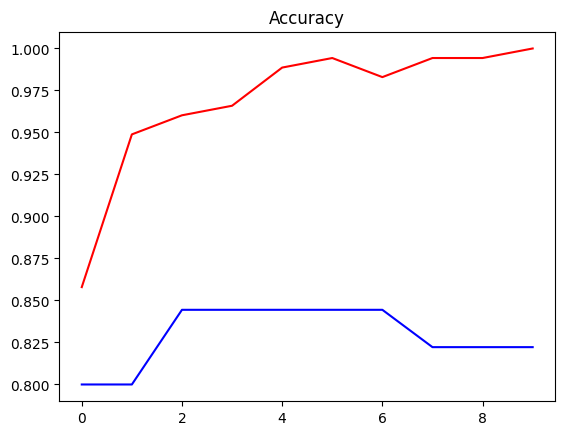

In [ ]:
#Plot the accuracy
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

2/2 [==============================] - 4s 1s/step - loss: 15.5027 - accuracy: 0.8393
Test accuracy: 0.8392857313156128


In [ ]:
def preprocess1(file_path):
    # Load the WAV file and convert it to a tensor
    wav = load_wav_16k_mono(file_path)
    # Trim the audio to 25000 samples
    wav = wav[:25000]
    # Add zero padding to make the length 25000
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    # Compute the Short-Time Fourier Transform (STFT) of the audio
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # Compute the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)
    # Add a channel dimension to the spectrogram
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    spectrogram=tf.expand_dims(spectrogram, axis=-1)
    return spectrogram

In [ ]:
a=preprocess1("/content/drive/MyDrive/arc/cats_dogs/cat_100.wav")
a.shape

TensorShape([1, 772, 257, 1])

In [ ]:
b=model.predict(a)

1/1 [==============================] - 0s 421ms/step


In [ ]:
b

array([[0.]], dtype=float32)

In [ ]:
c=np.argmax(b)
c

0

In [ ]:
label_encoder.inverse_transform([c])[0]


'cat'

In [ ]:
#Save the model as pickle file for serialization
import pickle
pickle_out=open('/content/drive/MyDrive/arc/class_model.pkl','wb')
pickle.dump(model,pickle_out)
pickle_out.close()


In [ ]:
#save the label_encoder as pickle file
pickle_out=open('/content/drive/MyDrive/arc/label_encoder.pkl','wb')
pickle.dump(label_encoder,pickle_out)
pickle_out.close()